In [80]:
%matplotlib inline

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from warnings import filterwarnings

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LinDA
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, plot_roc_curve, confusion_matrix

from scipy.cluster.hierarchy import linkage, dendrogram

# Titanic Dataset - Final Project

### Welcome to my project for the machine learning course.

## 1. Introduction - Data Science

<p style='font-family: "Lucida Console", Courier, monospace'>First, let's remove the warning messages.</p>

In [82]:
np.random.seed(42)
filterwarnings('ignore')

<p style='font-family: "Lucida Console", Courier, monospace'>We read the data from the file and remove the columns of names and passengerid, as it is unnecessary information. I save the information in <b>data</b> variable.</p>

In [83]:
data = pd.read_csv('titanic_dataset.csv')
data = data.drop(columns = ['Name', 'PassengerId'])

<p style='font-family: "Lucida Console", Courier, monospace'>So now let's see some information about the data.</p>

In [84]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


<p style='font-family: "Lucida Console", Courier, monospace'>As we can see, the column of tickets is very diverse and can only hinder the training of the model. That's why I remove it.</p>

In [85]:
data = data.drop(columns = ['Ticket'])

In [86]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


<p style='font-family: "Lucida Console", Courier, monospace'>Let's create a function to check how many elements are missing from each column.</p>

In [87]:
def count_of_nan_values(data):
    for i in range(len(data.columns)):
        print('{}: {}/{} NaN values'.format(data.columns[i], data[data.columns[i]].isnull().sum(), data.shape[0]))

In [88]:
count_of_nan_values(data)

Survived: 0/891 NaN values
Pclass: 0/891 NaN values
Sex: 0/891 NaN values
Age: 177/891 NaN values
SibSp: 0/891 NaN values
Parch: 0/891 NaN values
Fare: 0/891 NaN values
Cabin: 687/891 NaN values
Embarked: 2/891 NaN values


<p style='font-family: "Lucida Console", Courier, monospace'>In three of the columns we have missing data. We have too many in the <b>Cabin</b> column. There are several possible approaches. One of them is to remove the columns with missing data, but this way the models will have nothing to train on. The second option is to delete the samples with NaN values, but we still come to a problem with training. What I chose to do was fill in the missing information.</p><hr>

<p style='font-family: "Lucida Console", Courier, monospace'>Let's see what part of our data refers to <b>class 0</b> and <b>class 1</b>.</p>

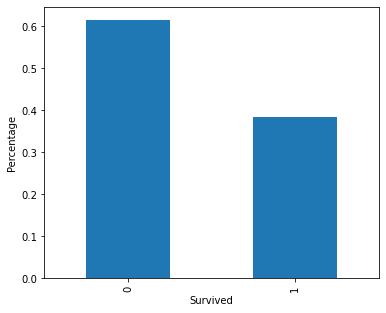

In [89]:
plt.figure(figsize = (6, 5))
data.Survived.value_counts(normalize = True).plot(kind = 'bar')
plt.xlabel('Survived')
plt.ylabel('Percentage')
plt.show()

<p style='font-family: "Lucida Console", Courier, monospace'>Those that are from <b>class 1</b> are about <b>40%</b> and respectively from <b>class 0</b> about <b>60%</b>. In my opinion, the data do not need oversampling.</p><hr>

<p style='font-family: "Lucida Console", Courier, monospace'>Now what needs to be done is to fill in the <b>NaN values</b>.</p>

<p style='font-family: "Lucida Console", Courier, monospace'>Let's start with the <b>Age</b> column. Each missing value in this column will be replaced by the <b>median</b> age of the people of the respective <b>Sex</b> in the respective <b>Pclass</b>.</p>

In [90]:
data['Age_fill'] = data.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
data = data.drop(columns = ['Age'])

<p style='font-family: "Lucida Console", Courier, monospace'>In the <b>Embarked</b> column we have only <b>2 missing values</b> out of a total of <b>891</b>. What we can do is write in their place the value that is most common in the <b>Embarked</b> column.</p>

In [91]:
data[data['Embarked'].isnull()]

,Survived,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,Age_fill
61,1,1,female,0,0,80.0,B28,NaN,38.0
829,1,1,female,0,0,80.0,B28,NaN,62.0


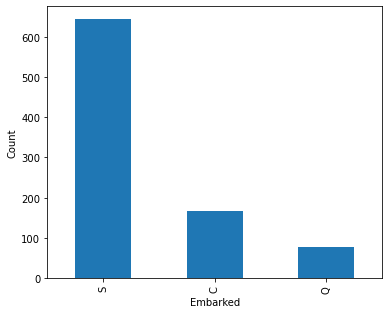

In [92]:
plt.figure(figsize = (6, 5))
data.Embarked.value_counts().plot(kind = 'bar')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.show()

In [93]:
data['Embarked'] = data['Embarked'].fillna('S')

<p style='font-family: "Lucida Console", Courier, monospace'>The <b>Cabin</b> column remained. I will make a new column <b>cabin</b> in which the values will be only <b>0</b> and <b>1</b>. <b>0</b> instead of <b>NaN</b>, and <b>1</b> instead of the <b>original value</b>.</p>

In [94]:
data['cabin'] = data['Cabin'].notnull().astype('int')

<p style='font-family: "Lucida Console", Courier, monospace'>Now let's see how many people in each <b>Pclass</b> have lost information about their <b>cabin</b>.</p>

<AxesSubplot:xlabel='Pclass', ylabel='count'>

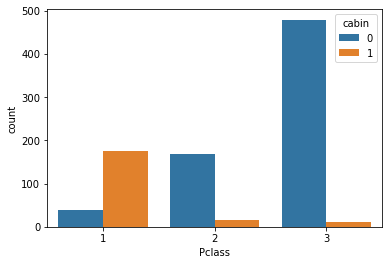

In [95]:
sb.countplot(x = 'Pclass', hue = 'cabin', data = data)

<p style='font-family: "Lucida Console", Courier, monospace'>And now let's see from the survivors and the dead how much of the <b>cabin</b> information is lost.</p>

<AxesSubplot:xlabel='Survived', ylabel='count'>

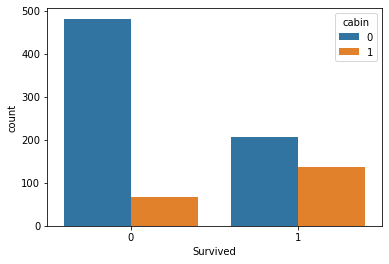

In [96]:
sb.countplot(x = 'Survived', hue = 'cabin', data = data)

In [97]:
print('Survived in each Pclass:\n', data.groupby(['Pclass'])['Survived'].sum(), end='\n' * 2)
print('Survived in each Pclass where Cabin is NaN:\n', data[data['Cabin'].isnull()].groupby(['Pclass'])['Survived'].sum())

Survived in each Pclass:
 Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64

Survived in each Pclass where Cabin is NaN:
 Pclass
1     19
2     74
3    113
Name: Survived, dtype: int64


<p style='font-family: "Lucida Console", Courier, monospace'>Most passengers in <b>Pclass 2</b> and <b>3</b> lost cabin information!</p>

<p style='font-family: "Lucida Console", Courier, monospace'>For many of the people who did not survive, there is no information in which <b>cabin</b> they were. So let's leave the <b>cabin</b> column with information whether there is data or not.</p>

In [98]:
data = data.drop(columns = ['Cabin'])

<p style='font-family: "Lucida Console", Courier, monospace'>So now let's convert all <b>categorical variables</b> into <b>indicator variables</b>.</p>

In [99]:
data['Sex'] = data['Sex'].replace({'male': 1, 'female': 0})
data = pd.get_dummies(data)

<p style='font-family: "Lucida Console", Courier, monospace'>We check if we have missing values for one last time.</p>

In [100]:
count_of_nan_values(data)

Survived: 0/891 NaN values
Pclass: 0/891 NaN values
Sex: 0/891 NaN values
SibSp: 0/891 NaN values
Parch: 0/891 NaN values
Fare: 0/891 NaN values
Age_fill: 0/891 NaN values
cabin: 0/891 NaN values
Embarked_C: 0/891 NaN values
Embarked_Q: 0/891 NaN values
Embarked_S: 0/891 NaN values


<p style='font-family: "Lucida Console", Courier, monospace'>We check what the data looks like after the changes.</p>

In [101]:
data.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Age_fill,cabin,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,1,0,7.2500,22.0,0,0,0,1
1,1,1,0,1,0,71.2833,38.0,1,1,0,0
2,1,3,0,0,0,7.9250,26.0,0,0,0,1
3,1,1,0,1,0,53.1000,35.0,1,0,0,1
4,0,3,1,0,0,8.0500,35.0,0,0,0,1


<p style='font-family: "Lucida Console", Courier, monospace'>That is, our data is ready for training.</p>

## 2. Supervised Learning

<p style='font-family: "Lucida Console", Courier, monospace'>First, let's separate <b>features</b> and <b>labels</b>.</p>

In [102]:
data_features = data.drop(columns = ['Survived'])
data_target = data.Survived

<p style='font-family: "Lucida Console", Courier, monospace'>Now we split the data into <b>training</b> and <b>testing set</b>, with <b>80%</b> of the data for training.</p>

In [103]:
data_features_train, data_features_test, data_target_train, data_target_test = train_test_split(
    data_features, data_target, train_size = 0.8)

<p style='font-family: "Lucida Console", Courier, monospace'>In my opinion, it is best to make a <b>dictionary</b> where to store the results of the algorithms.</p>

<p style='font-family: "Lucida Console", Courier, monospace'>We'll make <b>StratifiedKFold</b> validation with <b>5 splits</b>.</p>

In [104]:
estimators = {}
k_fold = StratifiedKFold(n_splits = 5)

<p style='font-family: "Lucida Console", Courier, monospace'>It's better to create <b>two functions</b> to plot <b>Confusion Matrix</b> and <b>Roc Curve</b> for each model.</p>

<p style='font-family: "Lucida Console", Courier, monospace'>And <b>two</b> more to <b>show</b> and <b>save metrics</b>, and also to <b>print</b> the <b>accuracy</b> of <b>training and testing set</b>.</p>

In [105]:
def plot_confusion_matrix(estimator, features, target, title = None):
    cm = confusion_matrix(target, estimator.predict(features), normalize = "all")
    plt.figure(figsize = (5, 5))
    if title is not None:
        plt.title(title)
    sb.heatmap(
        cm, 
        annot = cm, 
        fmt = ".3%", 
        cmap = plt.cm.Greens, 
        xticklabels = estimator.classes_,
        yticklabels = estimator.classes_)
    plt.show()
    
def show_roc_curve(estimator, features, target):
    plt.figure(figsize = (18, 12))
    plot_roc_curve(estimator, data_features_test, data_target_test, alpha = 1, lw = 1)
    plt.show()
    
def show_and_save_metrics(estimator, title, features_test, target_test):
    estimators[title] = accuracy_score(target_test, estimator.predict(features_test))
    p, r, f1 = precision_recall_fscore_support(target_test, estimator.predict(features_test))[:3]
    print('Precision: {}, Recall: {}, f1 score: {}'.format(p, r, f1))
    
def train_test_accuracy(estimator, features_train, features_test, target_train, target_test):
    print('Test set accuracy: {}'.format(accuracy_score(target_test, estimator.predict(features_test))))
    print('Train set accuracy: {}'.format(accuracy_score(target_train, estimator.predict(features_train))))

### 2.1. DecisionTreeClassifier

<p style='font-family: "Lucida Console", Courier, monospace'>I use <b>cross-validation</b> to <b>train</b> and <b>optimize</b> the <b>hyperparameters</b> for a <b>decision tree classifier</b>.</p>

<p style='font-family: "Lucida Console", Courier, monospace'>It's important to mention that I'm <b>not scaling</b> the data yet because I expect <b>decision tree classifier</b> and <b>random forest classifier</b> to do <b>better that way</b>.</p>

In [106]:
params = {
    'max_depth': [2, 4, 6, 8],
    "min_samples_leaf": [2, 5, 10, 12, 15],
    'max_leaf_nodes': [5, 10, 20]
}

tree = DecisionTreeClassifier()
grid_search = GridSearchCV(tree, params, scoring = 'accuracy', cv = k_fold)
grid_search.fit(data_features_train, data_target_train)
tree = grid_search.best_estimator_

<p style='font-family: "Lucida Console", Courier, monospace'>I'm curious to see what the tree looks like, so let's show it.</p>

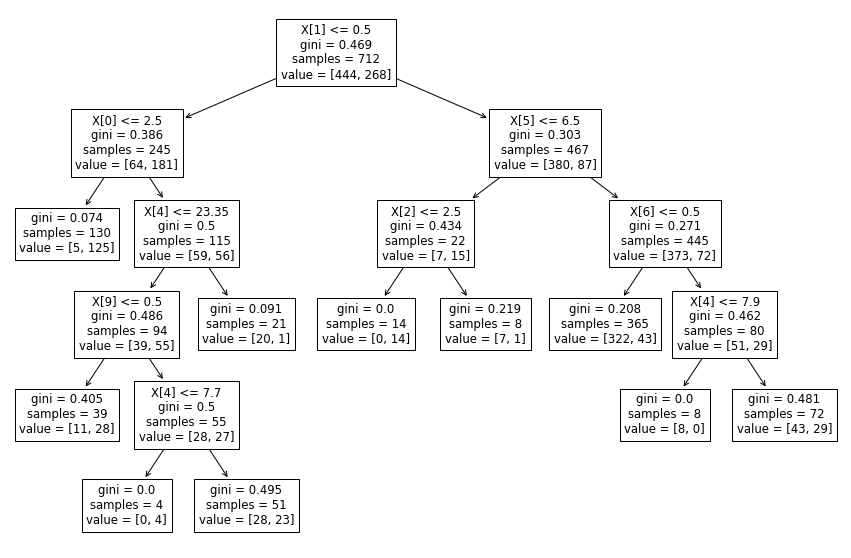

In [107]:
plt.figure(figsize = (15, 10))
plot_tree(tree)
plt.show()

<p style='font-family: "Lucida Console", Courier, monospace'>The <b>metric</b> I'm interested in is <b>accuracy</b>. I <b>save the accuracy of the model in the array</b>, but let's show the <b>other metrics</b> too.</p>

In [108]:
show_and_save_metrics(tree, 'Decision Tree', data_features_test, data_target_test)

Precision: [0.77868852 0.8245614 ], Recall: [0.9047619  0.63513514], f1 score: [0.83700441 0.71755725]


In [109]:
train_test_accuracy(tree, data_features_train, data_features_test, data_target_train, data_target_test)

Test set accuracy: 0.7932960893854749
Train set accuracy: 0.8412921348314607


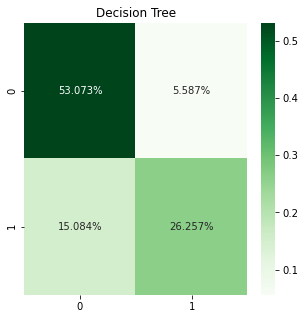

<Figure size 1296x864 with 0 Axes>

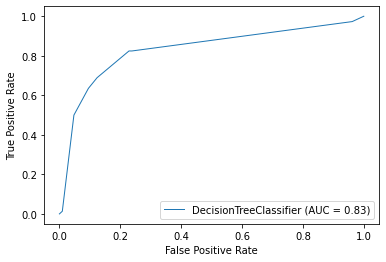

In [110]:
plot_confusion_matrix(tree, data_features_test, data_target_test, 'Decision Tree')
show_roc_curve(tree, data_features_test, data_target_test)

<p style='font-family: "Lucida Console", Courier, monospace'>We may have a <b>small overfit</b>, but the model is doing well. Let's see how others will cope.</p>

### 2.2. RandomForestClassifier

<p style='font-family: "Lucida Console", Courier, monospace'>We train <b>random forest classifier</b> with <b>grid search</b> as we did with <b>decision tree classifier</b>.</p>

In [111]:
params = {
    'max_depth': [2, 4, 8, 16, 32],
    'n_estimators': [100, 150, 200, 250]
}

forest = RandomForestClassifier()
grid_search = GridSearchCV(forest, params, scoring = 'accuracy', cv = k_fold)
grid_search.fit(data_features_train, data_target_train)
forest = grid_search.best_estimator_

<p style='font-family: "Lucida Console", Courier, monospace'>Again, we <b>save the accuracy of the model</b> and show the other metrics as well.</p>

In [112]:
show_and_save_metrics(forest, 'Random Forest', data_features_test, data_target_test)

Precision: [0.80869565 0.8125    ], Recall: [0.88571429 0.7027027 ], f1 score: [0.84545455 0.75362319]


In [113]:
train_test_accuracy(forest, data_features_train, data_features_test, data_target_train, data_target_test)

Test set accuracy: 0.8100558659217877
Train set accuracy: 0.9213483146067416


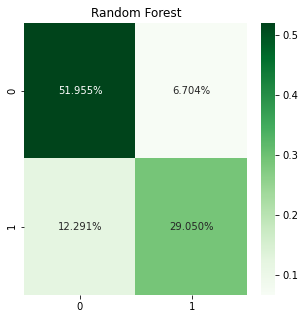

<Figure size 1296x864 with 0 Axes>

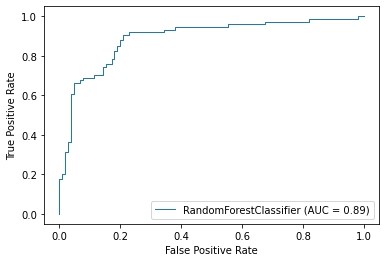

In [114]:
plot_confusion_matrix(forest, data_features_test, data_target_test, 'Random Forest')
show_roc_curve(forest, data_features_test, data_target_test)

<p style='font-family: "Lucida Console", Courier, monospace'>It seems to have a <b>small overfit</b> too, but the model is doing well.</p>

### 2.3. LogisticRegression

<p style='font-family: "Lucida Console", Courier, monospace'>Now I want to see what will do <b>logistic regression without scaled data</b>.</p>

In [115]:
params = {
    'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    'penalty': ['l1', 'l2']
}

logR = LogisticRegression()
grid_search = GridSearchCV(logR, params, scoring = 'accuracy', cv = k_fold)
grid_search.fit(data_features_train, data_target_train)
logR = grid_search.best_estimator_

<p style='font-family: "Lucida Console", Courier, monospace'>We save the result in the array.</p>

In [116]:
show_and_save_metrics(logR, 'Logistic Regression', data_features_test, data_target_test)

Precision: [0.81818182 0.7826087 ], Recall: [0.85714286 0.72972973], f1 score: [0.8372093  0.75524476]


In [117]:
train_test_accuracy(logR, data_features_train, data_features_test, data_target_train, data_target_test)

Test set accuracy: 0.8044692737430168
Train set accuracy: 0.8103932584269663


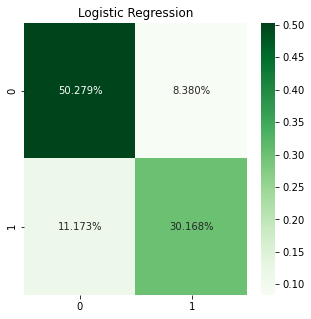

<Figure size 1296x864 with 0 Axes>

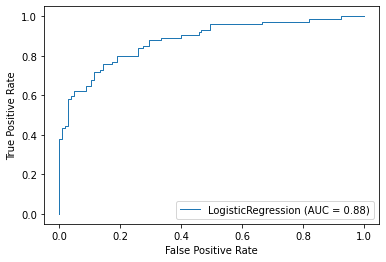

In [118]:
plot_confusion_matrix(logR, data_features_test, data_target_test, 'Logistic Regression')
show_roc_curve(logR, data_features_test, data_target_test)

<p style='font-family: "Lucida Console", Courier, monospace'>Not the best result, but it is satisfactory. The scores are close and I would not say that there is an overfit.</p>

<p style='font-family: "Lucida Console", Courier, monospace'>Now <b>after scaling</b> the data I will try again.</p>

In [119]:
data_features_train_scaled = MinMaxScaler().fit_transform(data_features_train)
data_features_test_scaled = MinMaxScaler().fit_transform(data_features_test)

### 2.4. Scaled LogisticRegression

<p style='font-family: "Lucida Console", Courier, monospace'>I'll do <b>grid search</b> with <b>same values</b>.</p>

In [120]:
params = {
    'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    'penalty': ['l1', 'l2']
}

logR_scaled = LogisticRegression()
grid_search = GridSearchCV(logR_scaled, params, scoring = 'accuracy', cv = k_fold)
grid_search.fit(data_features_train_scaled, data_target_train)
logR_scaled = grid_search.best_estimator_

In [121]:
show_and_save_metrics(logR_scaled, 'Logistic Regression Scaled', data_features_test_scaled, data_target_test)

Precision: [0.83636364 0.8115942 ], Recall: [0.87619048 0.75675676], f1 score: [0.85581395 0.78321678]


In [122]:
train_test_accuracy(
    logR_scaled, data_features_train_scaled, data_features_test_scaled, data_target_train, data_target_test)

Test set accuracy: 0.8268156424581006
Train set accuracy: 0.8033707865168539


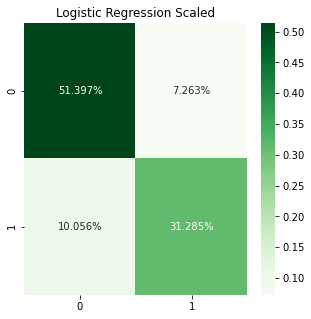

<Figure size 1296x864 with 0 Axes>

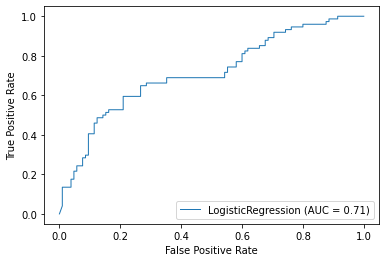

In [123]:
plot_confusion_matrix(logR_scaled, data_features_test_scaled, data_target_test, 'Logistic Regression Scaled')
show_roc_curve(logR_scaled, data_features_test_scaled, data_target_test)

<p style='font-family: "Lucida Console", Courier, monospace'>I notice that for <b>most metrics</b> it performs even <b>better than non-scaled logistic regression</b>.</p>

### 2.5. SVM

<p style='font-family: "Lucida Console", Courier, monospace'>Finally, let's see what <b>support vector classifier</b> will do.</p>

In [124]:
params = {
    'C': [1e-2, 1e-1, 1, 1e1, 1e2],
    'kernel': ['rbf', 'linear']
}

svm = SVC()
grid_search = GridSearchCV(svm, params, scoring = 'accuracy', cv = k_fold)
grid_search.fit(data_features_train_scaled, data_target_train)
svm = grid_search.best_estimator_

In [125]:
show_and_save_metrics(svm, 'SVM', data_features_test_scaled, data_target_test)

Precision: [0.81818182 0.7826087 ], Recall: [0.85714286 0.72972973], f1 score: [0.8372093  0.75524476]


In [126]:
train_test_accuracy(
    svm, data_features_train_scaled, data_features_test_scaled, data_target_train, data_target_test)

Test set accuracy: 0.8044692737430168
Train set accuracy: 0.8314606741573034


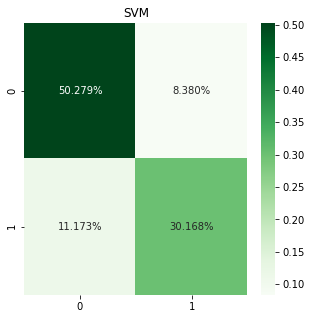

<Figure size 1296x864 with 0 Axes>

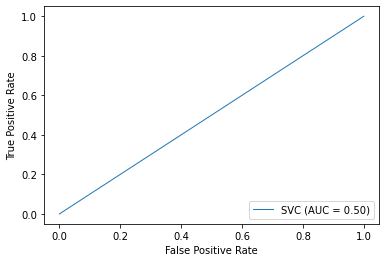

In [127]:
plot_confusion_matrix(svm, data_features_test_scaled, data_target_test, 'SVM')
show_roc_curve(svm, data_features_test_scaled, data_target_test)

<p style='font-family: "Lucida Console", Courier, monospace'>The <b>accuracy</b> here was clear before we made the model itself - it is the same as that of <b>logistic regression</b>, because we have only <b>2 classes</b>.</p>

<p style='font-family: "Lucida Console", Courier, monospace'>Let's check the <b>kernel</b> and to try with <b>different one</b>.</p>

In [128]:
svm.kernel

'rbf'

<p style='font-family: "Lucida Console", Courier, monospace'>Now I will <b>train</b> a <b>SVM model</b> with <b>linear kernel</b>.</p>

In [129]:
linear_svm = SVC(kernel = 'linear')
linear_svm.fit(data_features_train_scaled, data_target_train)

SVC(kernel='linear')

In [130]:
show_and_save_metrics(linear_svm, 'Linear SVM', data_features_test_scaled, data_target_test)

Precision: [0.8        0.75362319], Recall: [0.83809524 0.7027027 ], f1 score: [0.81860465 0.72727273]


In [131]:
train_test_accuracy(
    linear_svm, data_features_train_scaled, data_features_test_scaled, data_target_train, data_target_test)

Test set accuracy: 0.7821229050279329
Train set accuracy: 0.7879213483146067


<p style='font-family: "Lucida Console", Courier, monospace'>The <b>results</b> are a <b>bit lower</b>, but the <b>performance</b> of <b>linear svm</b> is <b>excellent</b>.</p>

<p style='font-family: "Lucida Console", Courier, monospace'>Now I will <b>sort</b> the <b>results</b> of the <b>models</b> and see what their <b>performance</b> is.</p>

In [132]:
estimators = {k: v for k, v in sorted(estimators.items(), key = lambda item: item[1])}

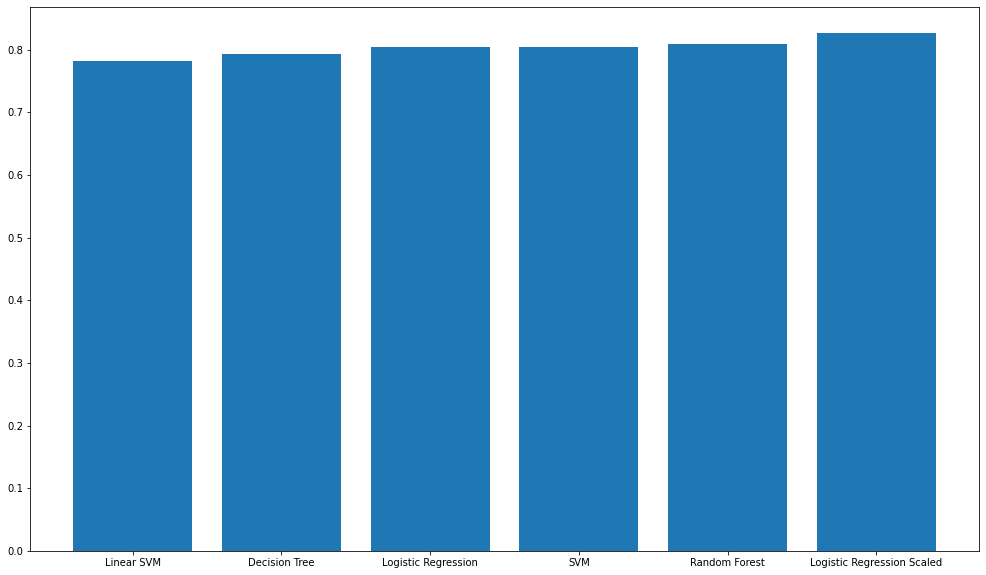

In [133]:
plt.figure(figsize = (17, 10))
plt.bar(range(len(estimators)), list(estimators.values()), align = 'center')
plt.xticks(range(len(estimators)), list(estimators.keys()))
plt.show()

<p style='font-family: "Lucida Console", Courier, monospace'>All models perform well and the differences are very small.</p>

## 3. Unsupervised Learning

<p style='font-family: "Lucida Console", Courier, monospace'>Let's make the task even more interesting and see what the <b>unsupervised models</b> will do.</p>

### 3.1. KMeans

<p style='font-family: "Lucida Console", Courier, monospace'>I will make an <b>array</b> where to save the <b>results of unsupervised models</b> only.</p>

In [134]:
unsupervised_estimators = {}

In [135]:
k_means = KMeans(n_clusters = 2, init = 'k-means++')
k_means.fit(data_features)

KMeans(n_clusters=2)

<p style='font-family: "Lucida Console", Courier, monospace'>Let's make <b>our own function</b> to find the <b>accuracy</b> of the <b>model</b>.</p>

In [136]:
def clustering_metric(estimator, features):
    correct = 0
    estimator_answers = estimator.predict(features)
    for i in range(len(estimator_answers)):
        if estimator_answers[i] == data_target[i]:
            correct += 1
    return correct / len(features)

In [137]:
data_features.head()

,Pclass,Sex,SibSp,Parch,Fare,Age_fill,cabin,Embarked_C,Embarked_Q,Embarked_S
0,3,1,1,0,7.2500,22.0,0,0,0,1
1,1,0,1,0,71.2833,38.0,1,1,0,0
2,3,0,0,0,7.9250,26.0,0,0,0,1
3,1,0,1,0,53.1000,35.0,1,0,0,1
4,3,1,0,0,8.0500,35.0,0,0,0,1


<p style='font-family: "Lucida Console", Courier, monospace'>I will now show what our data look like in the plane.</p>

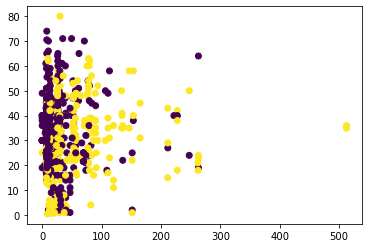

In [138]:
plt.figure(figsize = (6, 4))
plt.scatter(data_features.values[:, 4], data_features.values[:, 5], c = data_target)
plt.show()

<p style='font-family: "Lucida Console", Courier, monospace'>Let's check the <b>inertia</b> of the different <b>numbers of clusters</b>. Since we only have <b>2 classes</b> we know we need to have <b>2 clusters</b>, but let's see how <b>KMeans</b> will do best.</p>

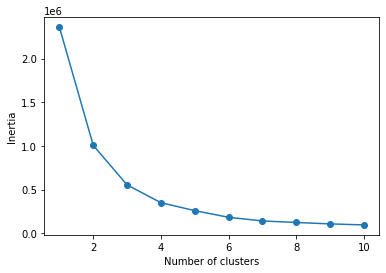

In [139]:
inertias = []
for i in range(1, 11):
    km = KMeans(n_clusters = i)
    km.fit(data_features)
    inertias.append(km.inertia_)
plt.plot(range(1,11), inertias, marker = "o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

<p style='font-family: "Lucida Console", Courier, monospace'>As we can see from the <b>graph</b>, it will work best with <b>2 clusters</b>, which is great for us.</p>

<p style='font-family: "Lucida Console", Courier, monospace'>We are checking what our <b>model</b> will <b>predict</b>.</p>

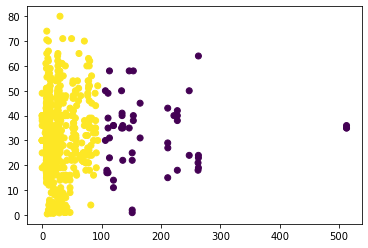

In [140]:
plt.figure(figsize = (6, 4))
plt.scatter(data_features.values[:, 4], data_features.values[:, 5], c = k_means.predict(data_features))
plt.show()

In [141]:
print(clustering_metric(k_means, data_features))
unsupervised_estimators['KMeans'] = clustering_metric(k_means, data_features)
estimators['KMeans'] = clustering_metric(k_means, data_features)

0.3557800224466891


<p style='font-family: "Lucida Console", Courier, monospace'>The <b>score</b> is really <b>bad</b>, we have to see how <b>AgglomerativeClustering</b> will cope.</p>

### 3.2. AgglomerativeClustering

<p style='font-family: "Lucida Console", Courier, monospace'>We do the same thing, we have <b>2 classes</b>, so <b>n_clusters = 2</b>.</p>

In [142]:
aggl_clustering = AgglomerativeClustering(n_clusters = 2)
aggl_clustering.fit(data_features)

AgglomerativeClustering()

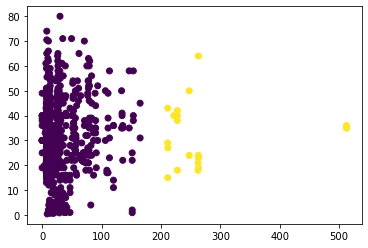

In [143]:
plt.figure(figsize = (6, 4))
plt.scatter(data_features.values[:, 4], data_features.values[:, 5], c = aggl_clustering.labels_)
plt.show()

<p style='font-family: "Lucida Console", Courier, monospace'>Let's make our own <b>metric</b> again to see the <b>result</b> of the <b>model</b>.</p>

In [144]:
aggl_score = 0
for i in range(len(data_target)):
    if data_target[i] == aggl_clustering.labels_[i]:
        aggl_score += 1
unsupervised_estimators['Aggl Clustering'] = aggl_score / len(data_target)
estimators['Aggl Clustering'] = aggl_score / len(data_target)
print(estimators['Aggl Clustering'])

0.6251402918069585


<p style='font-family: "Lucida Console", Courier, monospace'><b>AgglomerativeClustering</b> does much <b>better</b> work in our case.</p>

### 3.3. KMeans with PCA

<p style='font-family: "Lucida Console", Courier, monospace'>Now I want to try to see what <b>KMeans</b> will do with <b>PCA</b>.</p>

In [145]:
pca = PCA()
data_features_pca = pca.fit_transform(MinMaxScaler().fit(data_features).transform(data_features))

In [146]:
pca.explained_variance_ratio_

array([3.50901322e-01, 2.54641336e-01, 2.00152381e-01, 9.23419815e-02,
       4.54405054e-02, 2.54644637e-02, 1.64471384e-02, 9.64733838e-03,
       4.96353348e-03, 5.26961471e-31])

In [147]:
np.cumsum(pca.explained_variance_ratio_)

array([0.35090132, 0.60554266, 0.80569504, 0.89803702, 0.94347753,
       0.96894199, 0.98538913, 0.99503647, 1.        , 1.        ])

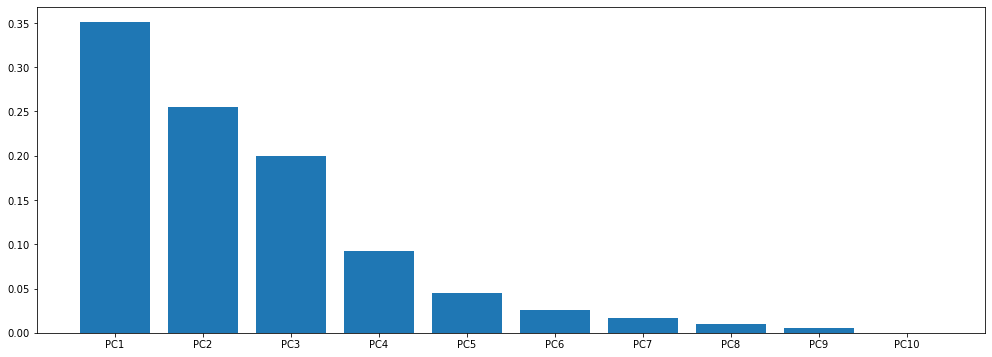

In [148]:
plt.figure(figsize = (17, 6))
plt.bar(range(len(pca.explained_variance_ratio_)), list(pca.explained_variance_ratio_), align = 'center')
plt.xticks(range(len(pca.explained_variance_ratio_)), ['PC{}'.format(i) for i in range(1, 1 + len(pca.explained_variance_ratio_))])
plt.show()

<p style='font-family: "Lucida Console", Courier, monospace'>Based on the information from <b>PCA</b>, I plan to try <b>KMeans</b> with only the first <b>4 features</b>.</p>

In [149]:
k_means_with_pca = KMeans(n_clusters = 2, init = 'k-means++')
k_means_with_pca.fit(data_features_pca[:, :4])

KMeans(n_clusters=2)

<p style='font-family: "Lucida Console", Courier, monospace'>Let's see what our data looks like in the <b>plane</b> now.</p>

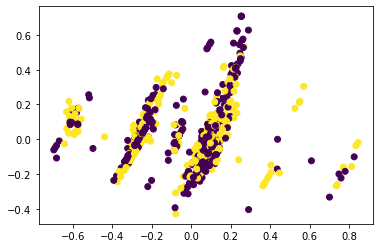

In [150]:
plt.figure(figsize = (6, 4))
plt.scatter(data_features_pca[:, 4], data_features_pca[:, 5], c = data_target)
plt.show()

<p style='font-family: "Lucida Console", Courier, monospace'>We are checking what our <b>model</b> will <b>predict</b>.</p>

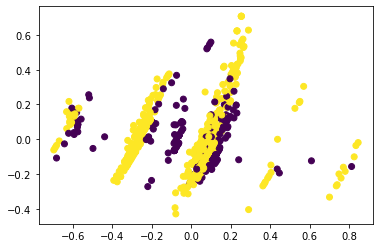

In [151]:
plt.figure(figsize = (6, 4))
plt.scatter(data_features_pca[:, 4], data_features_pca[:, 5], c = k_means_with_pca.predict(data_features_pca[:, :4]))
plt.show()

In [152]:
print(clustering_metric(k_means_with_pca, data_features_pca[:, :4]))
unsupervised_estimators['KMeans PCA'] = clustering_metric(k_means_with_pca, data_features_pca[:, :4])
estimators['KMeans PCA'] = clustering_metric(k_means_with_pca, data_features_pca[:, :4])

0.38271604938271603


<p style='font-family: "Lucida Console", Courier, monospace'>Again, we have an <b>unsatisfactory result</b>.</p>

### 3.4. KMeans with Linear Discriminant Analysis

<p style='font-family: "Lucida Console", Courier, monospace'>The default value of <b>n_components</b> in <b>LDA</b> is <b>min(n_classes - 1, n_features)</b>. So in our case the only possible value for <b>n_componens</b> is <b>1</b>.</p>

In [153]:
lda = LinDA()
lda.fit(MinMaxScaler().fit_transform(data_features), data_target)
data_features_lda = lda.transform(MinMaxScaler().fit_transform(data_features))

In [154]:
k_means_with_lda = KMeans(n_clusters = 2, init = 'k-means++')
k_means_with_lda.fit(data_features_lda)

KMeans(n_clusters=2)

In [155]:
print(clustering_metric(k_means_with_lda, data_features_lda))
unsupervised_estimators['KMeans LDA'] = clustering_metric(k_means_with_lda, data_features_lda)
estimators['KMeans LDA'] = clustering_metric(k_means_with_lda, data_features_lda)

0.8024691358024691


<p style='font-family: "Lucida Console", Courier, monospace'>The <b>score</b> is very <b>high</b>, which surprises me personally.</p>

<p style='font-family: "Lucida Console", Courier, monospace'>Let's see how the <b>unsupervised models</b> coped and finally <b>all of them in general</b>.</p>

In [156]:
estimators = {k: v for k, v in sorted(estimators.items(), key = lambda item: item[1])}
unsupervised_estimators = {k: v for k, v in sorted(unsupervised_estimators.items(), key = lambda item: item[1])}

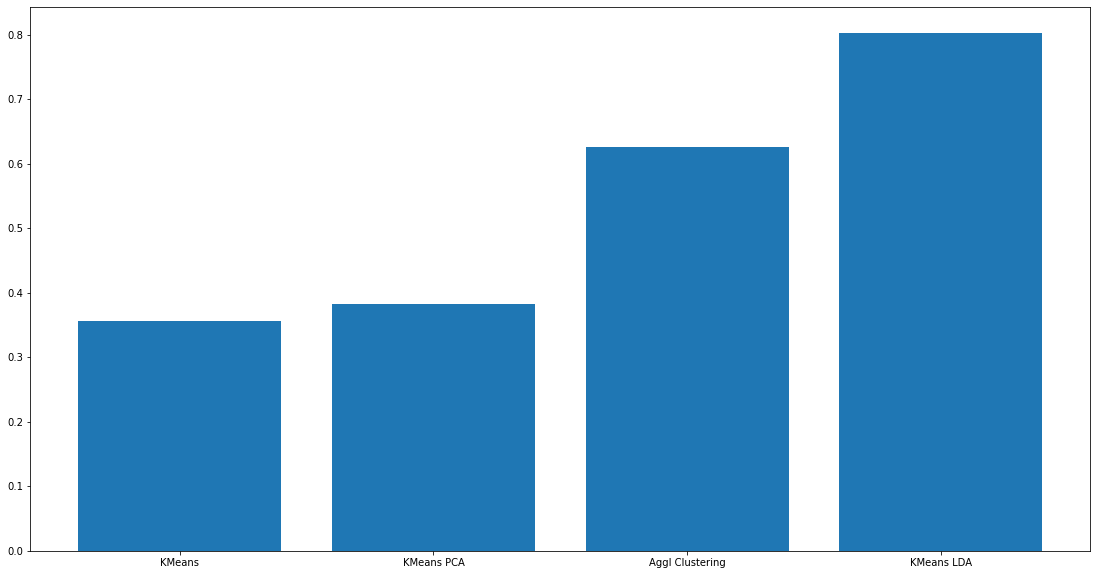

In [157]:
plt.figure(figsize = (19, 10))
plt.bar(range(len(unsupervised_estimators)), list(unsupervised_estimators.values()), align = 'center')
plt.xticks(range(len(unsupervised_estimators)), list(unsupervised_estimators.keys()))
plt.show()

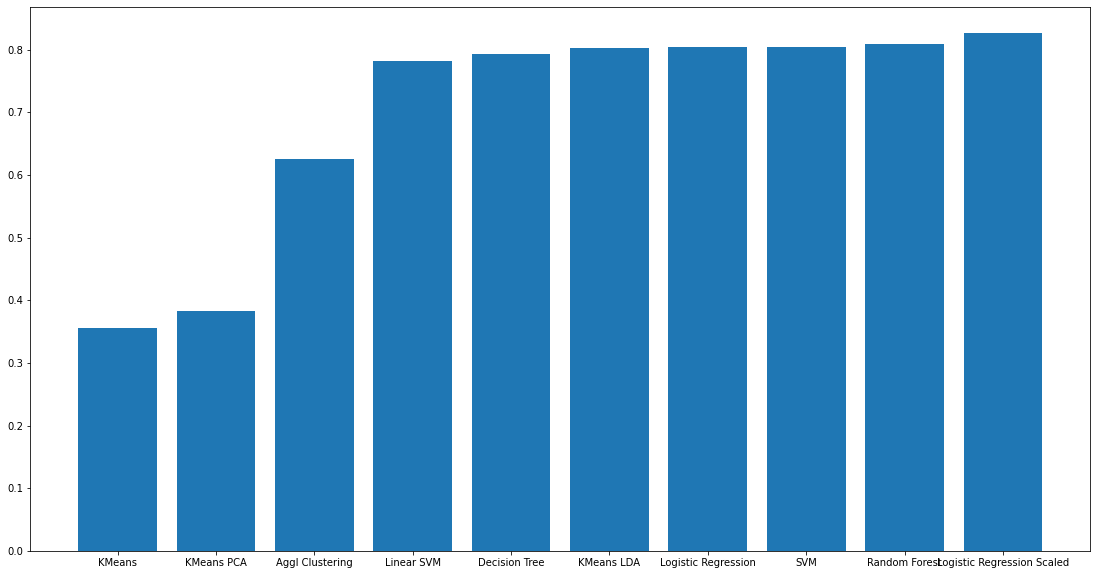

In [158]:
plt.figure(figsize = (19, 10))
plt.bar(range(len(estimators)), list(estimators.values()), align = 'center')
plt.xticks(range(len(estimators)), list(estimators.keys()))
plt.show()

<p style='font-family: "Lucida Console", Courier, monospace'>Some of the results surprised me a lot, but I think most of the models did well.</p>

<h2 style = 'text-align: center'>Thank you for your attention!</h2>

<h2 style='text-align: right'>Author: Samuil Ganev</h2>